# Training

In [1]:
from detectors import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score



In [2]:
def get_new_model(X, y, base_model=SVR):
    new_model = base_model()
    new_model.fit(X, y.ravel())
    return new_model

def cd_detected(pred_vec):
    for val in pred_vec:
        if val == 2:
            return True
    return False

# Building detectors

In [3]:
X_final, y_final = [], []
versions = ['9-100-conf-70',
            '9-100-conf-50',
            '6-100-conf-70',
            '6-100-conf-50',
            '4-100-conf-50',
            '4-100-conf-70',
           ]

# versions = ['6-100-conf-70',
#             '6-100-conf-50']

drift_n = [9, 9, 6,6, 4, 4]
res_mode = 'warn'

reset_mode = {'soft':0,
              'half':1,
              'warn':2,
              'hard':3,
             }

win_lens = [15*(i+1) for i in range(5)]
wrn_bds = np.arange(1.25, 2.75, 0.25).tolist()
dtc_bds = np.arange(2.95, 5, 0.25).tolist()

for i in range(len(versions)):
    data_version = versions[i]
    data_file = '../data/data-%s.csv'%(data_version)
    label_file = '../data/label-%s.csv'%(data_version)
    label_noised_file = '../data/label-noised-%s.csv'%(data_version)
    detectors_set = DetectorsSet(win_lens, wrn_bds, dtc_bds, reset_mode=reset_mode[res_mode])

    X = np.loadtxt(data_file, delimiter=",")
    y = np.loadtxt(label_file, delimiter=",")
    y_noised = np.loadtxt(label_noised_file, delimiter=",")
    X, y, y_noised = X.reshape((-1, 1)), y.reshape((-1, 1)), y_noised.reshape((-1, 1))

    # Dataset
    drift_number = drift_n[i]
    concept_len = 100
    detectors_outputs = []
    curr_model = None
    train_size = 50
    tolerance = 0.2

    curr_model = get_new_model(X[:train_size], y_noised[:train_size])
    for i in range(X.shape[0] + int(tolerance*concept_len)):

        if i % concept_len == int(tolerance*concept_len) and int(i/concept_len) > 0:
            concept_n = int(i/concept_len)
            start_idx_train = int(concept_n * concept_len)
            X_train = X[start_idx_train: start_idx_train + train_size]
            y_train = y_noised[start_idx_train: start_idx_train + train_size]
            print(i, concept_n, start_idx_train, y_train.shape)
            new_model = get_new_model(X_train, y_train)
            detectors_set.reset_detectors(new_model)

        if i >= X.shape[0]:
                next_sample, next_label = X[i - X.shape[0]], y[i - X.shape[0]]
        else:
            next_sample, next_label = X[i], y[i]   

        curr_pred = curr_model.predict([next_sample])
        detectors_prediction = detectors_set.predict(next_sample, curr_pred, next_label)
        detectors_outputs.append(detectors_prediction)

    out = np.array(detectors_outputs)  
    print('output shape ', out.shape)


    tol = 0.20
    for i, x in enumerate(detectors_outputs):
        curr_concept_pos = i % concept_len 
        if cd_detected(x):
            X_final.append(x[:])
            if int(i/concept_len) > 0 and curr_concept_pos < tolerance * concept_len:
                y_final.append(1)
            else:
                y_final.append(0)
    print(len(y_final), sum(y_final))

120 1 100 (50, 1)
220 2 200 (50, 1)
320 3 300 (50, 1)
420 4 400 (50, 1)
520 5 500 (50, 1)
620 6 600 (50, 1)
720 7 700 (50, 1)
820 8 800 (50, 1)
output shape  (920, 270)
122 34
120 1 100 (50, 1)
220 2 200 (50, 1)
320 3 300 (50, 1)
420 4 400 (50, 1)
520 5 500 (50, 1)
620 6 600 (50, 1)
720 7 700 (50, 1)
820 8 800 (50, 1)
output shape  (920, 270)
288 104
120 1 100 (50, 1)
220 2 200 (50, 1)
320 3 300 (50, 1)
420 4 400 (50, 1)
520 5 500 (50, 1)
output shape  (620, 270)
368 137
120 1 100 (50, 1)
220 2 200 (50, 1)
320 3 300 (50, 1)
420 4 400 (50, 1)
520 5 500 (50, 1)
output shape  (620, 270)
521 192
120 1 100 (50, 1)
220 2 200 (50, 1)
320 3 300 (50, 1)
output shape  (420, 270)
605 228
120 1 100 (50, 1)
220 2 200 (50, 1)
320 3 300 (50, 1)
output shape  (420, 270)
679 264


In [4]:
X, y = np.array(X_final), np.array(y_final)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [5]:
models_name = ['SVC', 'RF', 'KNN', 'LR']
base_models = {'SVC': SVC,
               'KNN':KNeighborsClassifier,
               'LR':LogisticRegression,
               'RF':RandomForestClassifier}
models = []
print('training models')
for model_name in models_name:
    print('training %s ...'%model_name)
    model = base_models[model_name]()
    model.fit(X_train, y_train)
    models.append(model)
    
print("testing model")
best_model = models[0]
best_score = 0
for i in range(len(models)):
    model = models[i]
    pred = model.predict(X_test)
    score = f1_score(y_pred=pred, y_true=y_test)
    best_model = best_model if best_score >= score else model
    best_score = best_score if best_score >= score else score
    print('score %s %f'%(models_name[i], score)) 

training models
training SVC ...
training RF ...
training KNN ...
training LR ...
testing model
score SVC 0.778947
score RF 0.933333
score KNN 0.842105
score LR 0.827586


# Testing

In [22]:
# tst : 6 conf 70/50, 7 conf 70/50
data_version = '7-100-conf-70-tst'
data_file = '../data/data-%s.csv'%(data_version)
label_file = '../data/label-%s.csv'%(data_version)
label_noised_file = '../data/label-noised-%s.csv'%(data_version)

X = np.loadtxt(data_file, delimiter=",")
y = np.loadtxt(label_file, delimiter=",")
y_noised = np.loadtxt(label_noised_file, delimiter=",")
X, y, y_noised = X.reshape((-1, 1)), y.reshape((-1, 1)), y_noised.reshape((-1, 1))


detectors_set_ = DetectorsSet(win_lens, wrn_bds, dtc_bds, reset_mode=reset_mode[res_mode] )
main_detector = MainDetector(detectors_set_, best_model)

In [23]:
concept_model = get_new_model(X[:50], y_noised[:50])
detections = []
for i in range(X.shape[0] + 20):
    if i >= X.shape[0]:
        sample, label = X[i - X.shape[0]], y[i - X.shape[0]]
    else:
        sample, label = X[i], y[i]
    pred = concept_model.predict([sample])[0]
    pred_cd = main_detector.predict(sample, pred, label)
    if pred_cd == 1:
        print(i)
        detections.append(i)
        main_detector.reset_detectors()

107
201
208
250
301
343
404
547


Text(0,0.5,'detection')

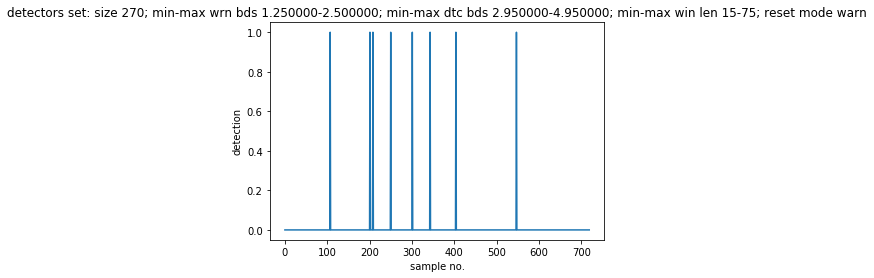

In [24]:
p = [1 if i in detections else 0 for i in range(X.shape[0] + 20)]
plt.plot(range(X.shape[0] + 20), p)

plt.title(main_detector.__str__())
plt.xlabel('sample no.')
plt.ylabel('detection')

<IPython.core.display.Javascript object>


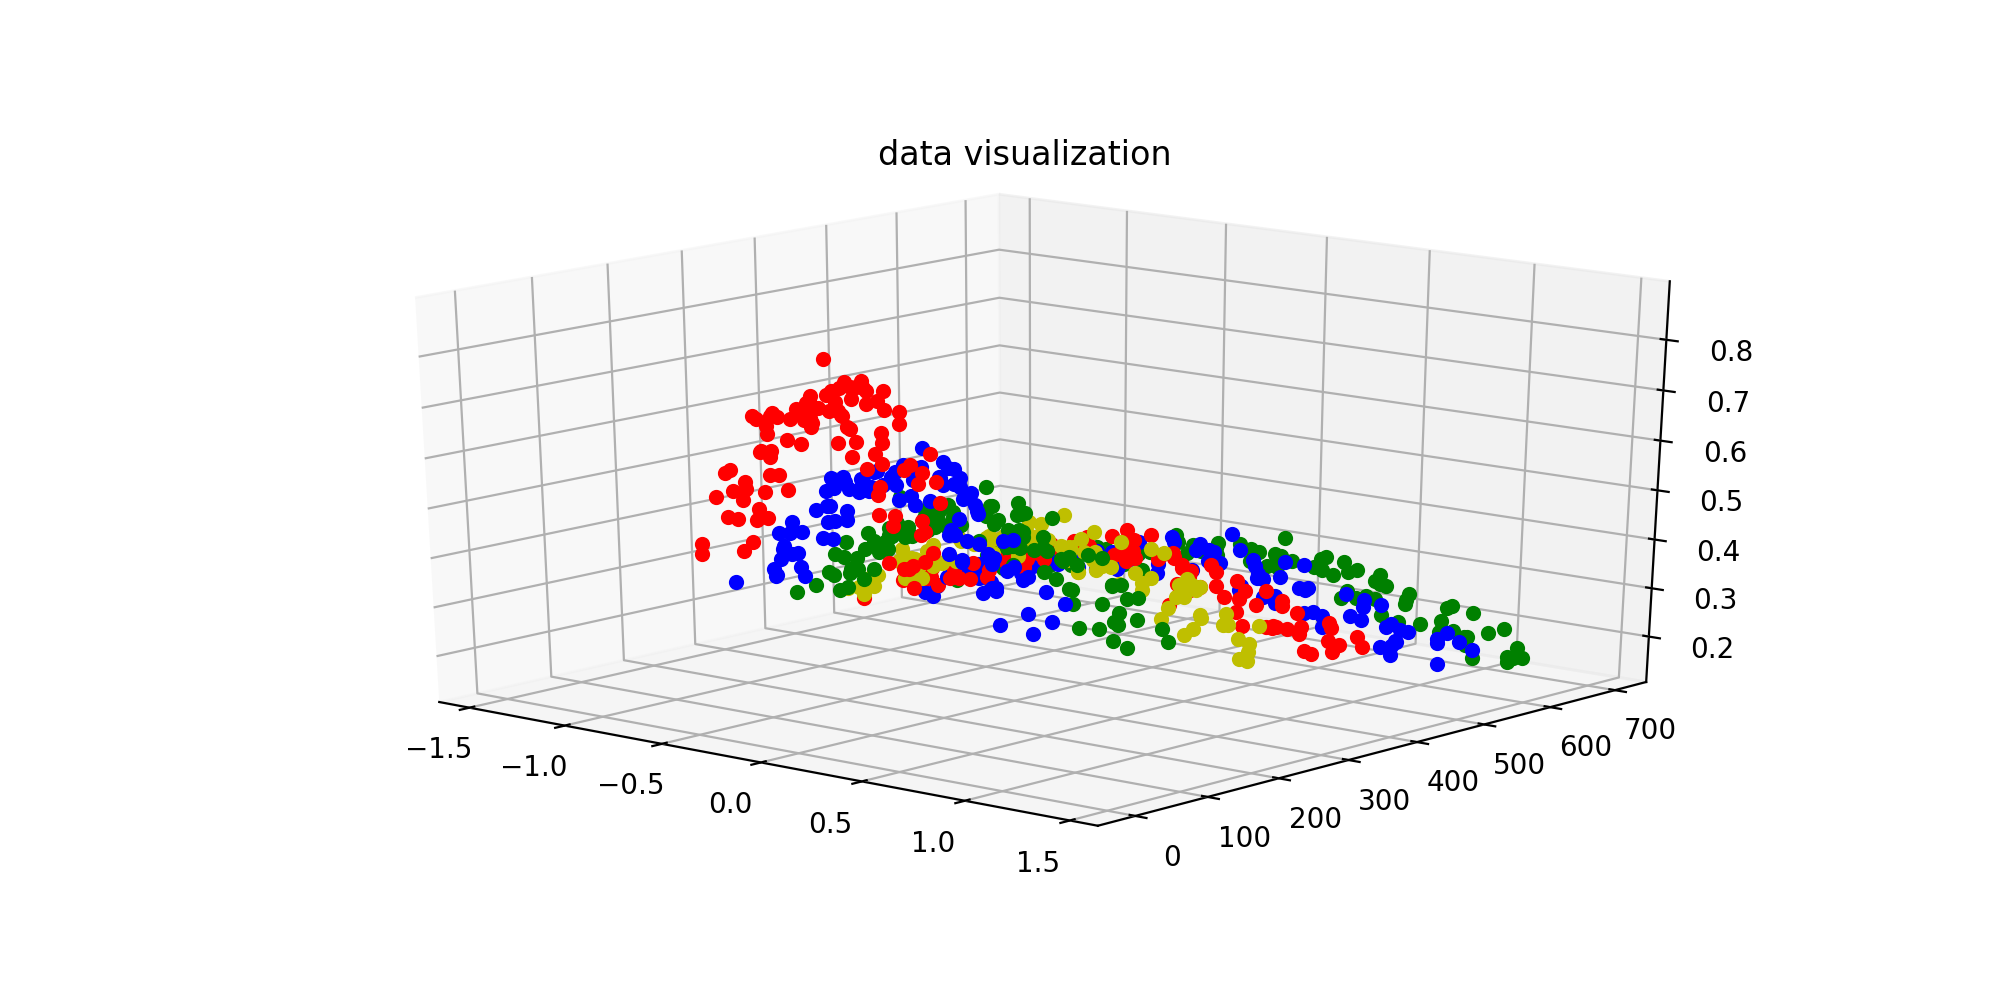

In [17]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("data visualization")
n = X.shape[0]
counter = 0
colors = ['r', 'b', 'g', 'y']
n_colors = len(colors)
for a, b, c in zip(X, y_noised, range(n-1)):
    ax.scatter(a, c, b, c=colors[int(counter/100)%n_colors], marker='o')
    counter += 1

ax.view_init(20, 270)